---

# IVADO/MILA ÉCOLE D'APPRENTISSAGE PROFOND

# 4e édition (automne 2019)

# Tutoriel sur les données catégorielles avec perceptron multicouche (MLP)

## Auteurs :

Arsène Fansi Tchango <arsene.fansi.tchango@mila.quebec>

Gaétan Marceau Caron <gaetan.marceau.caron@mila.quebec>

## Traducteur: 

Andrew Williams <andrew.williams@umomntreal.ca>


## Préface


Ce tutoriel présente les aspects pratiques de l'apprentissage profond par la réalisation d'un projet simple de bout en bout. Nous utiliserons la bibliothèque d'apprentissage profond <a href="https://pytorch.org/"> `PyTorch`</a>, qui est bien connue pour sa facilité d'utilisation.


# Introduction


## Chargement de bibliothèques et utilisation de GPU


Avant de commencer, nous installons les bibliothèques nécessaires pour le tutoriel à l'aide de pip. Pour ce faire, exécutez la cellule suivante en la sélectionnant et en utilisant `shift+Enter`. Cette étape peut prendre quelques minutes.


In [ ]:
!pip install 'torch==1.1.0' 'torchvision==0.3.0' 'Pillow==4.3.0' 'matplotlib==3.0.3'

Maintenant, importez tous les modules que nous allons utiliser pour ce tutoriel en exécutant la cellule suivante :


In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")


print("Version de torch: ", torch.__version__)
print("GPU disponible: {}".format(use_gpu))

Version de torch:  1.6.0
GPU disponible: False


## PyTorch en quelques mots


*PyTorch* est une bibliothèque Python qui soutien un écosystème dynamique d'outils et de bibliothèques pour l’AA en vision, TLN, et plus encore. Elle offre deux fonctionnalités de haut niveau :

<ul>
<li> opérations sur des <a href="https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py">tenseurs</a> (tels que NumPy) avec soutien pour GPU,</li>
<li> des opérations de création et d'optimisation de graphes de calcul avec un système de dérivation automatique appelé <a href="https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py">Autograd</a>.</li>
</ul>
<a href="https://pytorch.org/docs/stable/torch.html">Les documents PyTorch</a> contiennent la documentation API et <a href="https://pytorch.org/tutorials/">de nombreux tutoriels</a>. De plus, PyTorch offre plusieurs fonctionnalités de traitement de données. L'une de ces fonctionnalités est la classe <a href="http://pytorch.org/docs/master/data.html#"> `torch.utils.data.Dataset`</a> qui offre une interface facile à utiliser pour gérer un ensemble de données. Pour plus d'informations, référez-vous aux url suivantes :

<ul>
<li>Ensembles de données PyTorch: <a href="http://pytorch.org/docs/master/data.html"> PyTorch - datasets</a>.</li>
<li>Un tutoriel de téléchargement de données: <a href="http://pytorch.org/tutorials/beginner/data_loading_tutorial.html"> PyTorch - data loading tutorial</a>.</li>
</ul>
<a href="http://pytorch.org/docs/master/cuda.html#module-torch.cuda">`torch.cuda`</a> Est une bibliothèque qui fournit les mêmes fonctions que les tenseurs de CPU mais pour les tenseurs CUDA, qui sont utilisés pour le calcul sur GPU. <a href="http://pytorch.org/docs/master/cuda.html#torch.cuda.is_available">`torch.cuda.is_available()`</a> Retourne une valeur booléenne indiquant si CUDA est actuellement disponible. Enfin, nous vous recommandons d'utiliser une variable `device` qui identifie le périphérique sur lequel vous souhaitez effectuer des calculs. Nous pouvons affecter un tenseur à un périphérique avec la méthode `.to(device)`. Par défaut, les tenseurs sont des tenseurs de CPU.


## Ingrédients pour une preuve de concept (POC)


Pour réaliser un POC en AA, vous avez besoin de :

<ul>
<li>une description de la tâche ainsi que des données à l'appui,</li>
<li>une mesure d'évaluation pour évaluer la performance d'un modèle,</li>
<li>une description du modèle, </li>
<li>une fonction de coût à optimiser,</li>
<li>un optimiseur qui ajuste les paramètres du modèle.</li>
</ul>

# Comment préparer l’ensemble de données ?


Notre tâche est de prédire si un passager a survécu ou non au naufrage du Titanic seulement en fonction de la base des données des passagers.


## Ensemble de données Titanic


Nous pouvons télécharger le jeu de données Titanic à l'adresse suivante : https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true.<br/> Cet ensemble de données fournit des informations sur le sort de 1309 passagers du premier et unique voyage du bateau "RMS Titanic", résumé par le statut économique (classe), sexe, âge, informations familiales et survie. La plate-forme Kaggle utilise également cet ensemble de données comme une introduction à l'apprentissage automatique classique. Ici, nous l'utilisons pour introduire des concepts plus avancés liés à PyTorch et à l'apprentissage profond.

Nous utilisons la bibliothèque <a href="https://pandas.pydata.org/">Pandas</a> pour stocker le jeu de données en mémoire.


In [5]:
titanic_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true', 
    sep='\t', 
    index_col=None, 
    na_values=['NA']
)

# un aperçu des 5 premiers points de données
titanic_df.head()



,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


**La signification des différentes colonnes (caractéristiques) est la suivante**:

<ol>
  <li> <b>pclass</b>: Classe du passager (1 = première; 2 = deuxième; 3 = troisième) </li>
  <li> <b>survived</b>: Survécu? (0 = non; 1 = oui) </li>
  <li> <b>name</b>: Nom </li>
  <li> <b>sex</b>: Sexe </li>
  <li> <b>age</b>: Âge </li>
  <li> <b>sibsp</b>: Nombre de frères, soeurs, ou conjoints à bord </li>
  <li> <b>parch</b>: Nombre de parents ou d'enfants à bord </li>
  <li> <b>ticket</b>: Numéro de ticket </li>
  <li> <b>fare</b>: Tarif du passager </li>
  <li> <b>cabin</b>: Numéro de cabine </li>
  <li> <b>embarked</b>: Port d'embarquement (C = Cherbourg; Q = Queenstown; S = Southampton) </li>
  <li> <b>boat</b>: Bateau de sauvetage (si le passager a survécu) </li>
  <li> <b>body</b>: Numéro du corps (si le passager n'a pas survécu et que le corps a été retrouvé) </li>
  <li> <b>home.dest</b>: Destination du passager </li>
 </ol>

## Pré-traitement des données


### Sélection de caractéristique

Certaines caractéristiques ne sont pas pertinentes pour la tâche, par exemple :

<ol>
  <li> <b>name</b>: Nom </li>
  <li> <b>ticket</b>: Numéro du ticket </li>
  <li> <b>cabin</b>: Numéro de cabine </li>
  <li> <b>home.dest</b>: Destination du passager </li>
 </ol>
 
D'autres caractéristiques dévoilent la cible à prédire et les inclure serait de la triche:
<ol>
  <li> <b>boat</b>: Bateau de sauvetage (si le passager a survécu) </li>
  <li> <b>body</b>: Numéro du corps (si le passager n'a pas survécu et que le corps a été retrouvé)  </li>
 </ol>

In [6]:
titanic_preprocess_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.csv?raw=true', 
    sep=',', 
    index_col=None
)

titanic_preprocess_df.head()

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,0,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,0,0,0,1,0.9167,1,2,151.5500,0,0,1
2,0,1,0,0,1,0,2.0000,1,2,151.5500,0,0,1
3,0,1,0,0,0,1,30.0000,1,2,151.5500,0,0,1
4,0,1,0,0,1,0,25.0000,1,2,151.5500,0,0,1


### Encodage de Caractéristiques

Certaines caractéristiques sont des **variables catégorielles**, ce qui signifie qu'elles peuvent prendre un nombre fini de valeurs.

 <ol>
  <li> <b>pclass</b>: Classe du passager </li>
  <li> <b>sex</b>: Sexe </li>
  <li> <b>embarked</b>: Port d'embarquement </li>
 </ol>
Pour traiter les variables catégorielles, nous devons les encoder d'une manière qui n'implique pas un ordre arbitraire, comme l'utilisation de nombres naturels (par exemple, 1, 2, 3). <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">L’ encodage one-hot (1 parmi n)</a> est un moyen de le réaliser. Nous pouvons télécharger le jeu de données pré-traité à l'adresse suivante : https://github.com/afansi/winterschool18/blob/master/titanic\_prepocess.csv?raw=true . <br>La signification des variables encodées est la suivante :

<ol>
  <li> <b>survived</b>: Survécu? (0 = non; 1 = oui) </li>
  <li> <b>pclass_1</b>: (1 si passager en première classe; 0 sinon) </li>
  <li> <b>pclass_2</b>: (1 si passager en deuxième classe; 0 sinon) </li>
  <li> <b>pclass_3</b>: (1 si passager en troisième classe; 0 sinon) </li>
  <li> <b>sex_female</b>: (1 si passager est une femme; 0 sinon) </li>
  <li> <b>sex_male</b>: (1 si passager est un homme ; 0 sinon) </li>
  <li> <b>age</b>: Âge </li>
  <li> <b>sibsp</b>: Nombre de frères, soeurs, ou conjoints à bord </li>
  <li> <b>parch</b>: Nombre de parents ou d'enfants à bord </li>
  <li> <b>fare</b>: Tarif du passager </li>
  <li> <b>embarked_C</b>: (1 si Port d'embarquement = Cherbourg (C); 0 sinon) </li> 
  <li> <b>embarked_Q</b>: (1 si Port d'embarquement = Queenstown (Q); 0 sinon) </li> 
  <li> <b>embarked_S</b>: (1 si Port d'embarquement = Southampton (S); 0 sinon)</li> 
 </ol

## Partition Entraînement / validation / évaluation 


À ce stade, nous devons diviser l'ensemble de données en trois sous-ensembles:

<ol>
<li> <b> Train</b> (généralement 60% de l'ensemble de données): utilisé pour entraîner le modèle de classification. </li>   
<li> <b> Validation</b> (généralement 20% de l'ensemble de données): utilisé pour évaluer les hyper-paramètres sur un ensemble de données différent. </li>   
<li> <b> Test</b> (généralement 20% de l'ensemble de données): utilisé pour évaluer la performance de généralisation du modèle choisi sur un ensemble de données différent. </li>
</ol>
Nous utilisons la <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.split.html">fonction numpy.split</a> pour séparer notre ensemble de données en sous-ensembles.


In [7]:
train, validate, test = np.split(
    titanic_preprocess_df.sample(frac=1, random_state=seed), 
    [int(.6*len(titanic_preprocess_df)), int(.8*len(titanic_preprocess_df))])

# Retirez la colonne d'étiquettes de X et créez un vecteur d'étiquettes.
X_train = train.drop(['survived'], axis=1).values
y_train = train['survived'].values

X_val = validate.drop(['survived'], axis=1).values
y_val = validate['survived'].values

X_test = test.drop(['survived'], axis=1).values
y_test = test['survived'].values

## Ensemble de données dans PyTorch


Nous utiliserons la sous-classe <b><a href="http://pytorch.org/docs/master/data.html#"> `torch.utils.data.TensorDataset`</a> </b> pour manipuler ensemble les caractéristiques et les cibles d'un ensemble de données.


In [8]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())

val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

# Comment définir l'algorithme d'apprentissage ?


Un perceptron multicouche (MLP/PMC) est un simple graphe de calcul composé de "couches cachées", qui sont définies par deux modules: Une *transformation linéaire* suivie d'une *non-linéarité*. Le résultat d'une couche cachée est un vecteur appelé *représentation distribuée* où chaque composant est associé à plusieurs unités cachées.

Pour entraîner ce modèle, nous devons définir :

<ul>
<li>l'architecture du réseau en choisissant la fonction non linéaire et le nombre d'unités cachées par couche, </li>
<li>la fonction de coût et l'optimiseur.  </li>
</ul>
Pour résoudre notre tâche, nous allons utiliser un MLP avec les propriétés suivantes :

 <ul>
 <li> la dimension d'entrée du modèle est de 12,</li>
 <li> la dimension de sortie du modèle est de 2,</li>
 <li> la première dimension de la sortie est la probabilité de décès et la deuxième dimension est la probabilité de survie,</li>
  <li> le nombre de couches cachées est de 3, </li>
 <li> les dimensions des couches cachées sont respectivement de 20, 40, 20, </li>
 <li> la fonction d'activation est une ReLu pour toutes les couches cachées. </li>
 </ul>

## Comment définir un modèle dans PyTorch?


La <a href="https://pytorch.org/docs/stable/nn.html">bibliothèque PyTorch NN</a> contient de nombreuses classes utiles pour la création de graphes de calcul.

<ul>
<li> La classe <a href="http://pytorch.org/docs/master/nn.html#module">torch.nn.Module</a>: 
tout nouveau module doit hériter de cette classe ou de ses descendants (sous-classes).
</li>   
<li> La méthode `forward` : toute classe définissant un module doit implémenter la méthode `forward(...)`, qui définit la transformation des entrées en sorties.</li>  
<li> La classe <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a>: cette classe implémente une transformation linéaire. Par défaut, elle prend deux paramètres : 
    <ul>
    <li>`in_features`: la taille des données à l'entrée du module. </li>
    <li>`out_features`: la taille des données à la sortie du module. </li>
    </ul>
</li>
<li> Le module <a href="http://pytorch.org/docs/master/nn.html#torch-nn-functional">`torch.nn.functional`</a>: 
elle définit un ensemble de fonctions qui peuvent être appliquées directement à n'importe quel tenseur. À titre d'exemple, nous avons :
    <ul>
    <li> les fonctions non-linéaires: sigmoid(...), tanh(...), relu(...), etc...</li> 
    <li> les fonctions de coût : mse_loss(...), nll(...., cross_entropy(...), etc ...</li> 
    <li> les fonctions de régularisation: droupout(...), etc ... </li> 
    <li> ...</li> 
    </ul>
</li>
</ul>

Vous devez compléter les méthodes suivantes :

<ul>
<li>La méthode `__init__` qui définit les couches. </li>
<li>La méthode `forward(input)` qui retourne le `output` (sortie). </li>
</ul>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [13]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out

## Faire des prédictions avec un réseau de neurones


Maintenant, nous sommes prêts à tester notre réseau de neurones sur des données choisies au hasard.

Dans PyTorch, un modèle a deux modes différents : <ul> <li> <b>train</b>: utilisé pendant l’entraînement, </li> <li> <b>eval</b>: utilisé pendant l'inférence pour l'évaluation du modèle. </li> </ul> La distinction est importante car certains modules se comportent différemment selon ce mode. Nous utiliserons le mode <b>évaluation</b> dans cette section.


In [14]:
# Définition du modèle
neural_net = NeuralNet()
neural_net = neural_net.to(device)

# Activation du mode d'évaluation
neural_net = neural_net.eval()

# Sélectionner les 5 premiers points de données
data, target = val_dataset[0:5]
data = data.to(device)
target = target.to(device)

# Propagation avant des données à travers le modèle
output = neural_net(data)   # équivalent à neural_net.forward(data)

# Convertir les logits en probabilités avec la fonction softmax
output_proba = F.softmax(output, dim=1)

# Imprimer la probabilité
print(output_proba)

tensor([[0.5093, 0.4907],
        [0.5069, 0.4931],
        [0.5129, 0.4871],
        [0.5022, 0.4978],
        [0.4427, 0.5573]], grad_fn=<SoftmaxBackward>)


Les rangées définissent la sortie du réseau, en termes de probabilités sur deux classes : <b>deceased</b> (première colonne) ou <b>survived</b> (deuxième colonne), pour chacun des cinq points de données d'entrée. Prenons l'étiquette avec la probabilité maximale comme étiquette prédite et comparons-la à l'étiquette correcte.


In [15]:
# Impression des prédictions (classe avec la plus grande probabilité)
_, prediction = torch.max(output_proba, dim=1)

print('Prédiction du modèle')
print(prediction)

# Impression des vraies étiquettes
print("Données réelles")
print(target)

Prédiction du modèle
tensor([0, 0, 0, 0, 1])
Données réelles
tensor([0, 0, 0, 0, 0])


**Questions**

1. Quelle serait une façon simple de mesurer la performance du modèle ?
2. Comment notre modèle performe-t-il ?
3. Étant donné que le modèle n'est pas entraîné sur l’ensemble de données, constatez-vous un problème avec la mesure sélectionnée ?



**Réponses possibles** :


1.   Une mesure simple de la performance est l'exactitude, le nombre de prévisions correctes sur le nombre total d'exemples.
2.   Ce modèle a une exactitude de 4/5 = 80%.
3.   Avec l'exactitude, nous avons déjà un score de 80% avec un poids aléatoire, ce qui se produit lorsque les étiquettes sont déséquilibrées, et le modèle prédit la classe dominante par hasard. Dans cette section, nous n'utilisons que cinq exemples pour évaluer le modèle, ce qui n'est pas suffisant. Toutefois, si nous observons ce comportement sur tout l'ensemble de validation, nous pouvons alors considérer une autre mesure de performance (par exemple, la précision/le rappel ou le score F1).



## Définir la fonction de coût et l'optimiseur


### Fonction de coût


Nous définissons la fonction de coût en fonction de la tâche que nous voulons réaliser.

PyTorch offre <a href="https://pytorch.org/docs/stable/nn.html#loss-functions">de nombreuses fonctions de coût prêtes à utiliser</a>.

Pour les problèmes de classification, la fonction de coût habituelle est <b>l'entropie croisée</b>, et c'est celle que nous utiliserons dans ce tutoriel. Dans PyTorch, elle est définie par la fonction <a href="https://pytorch.org/docs/master/nn.functional.html#cross-entropy">`torch.nn.functional.cross_entropy`</a>.  L'entropie croisée permet de comparer une distribution $p$ avec une distribution de référence $t$. Elle atteint son minimum lorsque $t=p$. La formule pour la calculer avec la prédiction et la cible est la suivante : $-\sum_j t_{ij} \log(p_{ij})$ où $p$ est la prédiction, $t$ la cible, $i$ les exemples et $j$ les classes de la cible.


In [16]:
import torch.nn.functional as F


def cost_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

### Rétropropagation


Dans PyTorch, grâce au mécanisme de dérivation automatique <a href="http://pytorch.org/docs/master/notes/autograd.html">Autograd</a>, il est possible de calculer automatiquement le gradient de la fonction de coût et de la rétropropager à travers le graphe de calcul.

Pour ce faire, il suffit d'appeler la méthode `backward()` sur la variable retournée par la fonction de coût, par exemple, avec

`loss = cost_function(....)` <br> `loss.backward()`


### Optimisation


PyTorch fournit un <a href="http://pytorch.org/docs/master/optim.html#algorithms">ensemble de méthodes d'optimisation (`torch.optim`)</a> couramment utilisées par la communauté d'apprentissage profond. Ces méthodes incluent les suivantes :

<ul>
<li><b>SGD</b> (Descente de gradient stochastique) <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a></li>
<li><b>Adam</b> (Adaptive Moment Estimation) : une variante de la méthode de descente de gradient dans laquelle le taux d'apprentissage est ajusté pour chaque paramètre. Cet ajustement est basé sur l'estimation des premier et deuxième moments des gradients. Cet optimiseur a démontré d'excellentes performances par rapport à la méthode SGD sur de nombreuses tâches de référence. </li>
</ul>

Pour pouvoir utiliser un optimiseur dans PyTorch, nous devons l'instancier en passant les éléments suivants :

<ul>
<li><b>Les paramètres du modèle</b> : ils sont obtenus en utilisant la méthode <b>parameters()</b> sur le modèle instancié.</li>
    <li><b>Le taux d'apprentissage / <i>learning rate (lr)</i> </b>: c'est le taux d'apprentissage qui doit être utilisé pour mettre à jour les paramètres pendant le processus d'optimisation. </li>
<li>Il peut y avoir d'autres paramètres spécifiques à l'optimiseur choisi.</li>
</ul>

PyTorch offre une interface simplifiée pour interagir avec n'importe quel optimiseur :

<ul>
<li><b>zero_grad()</b>: Permet de réinitialiser les gradients à zéro au début d'une étape d'optimisation.</li>
<li><b>step()</b>: Permet d'effectuer une étape d'optimisation après une étape de rétropropagation de gradient.</li>
</ul>

Nous utiliserons Adam avec un taux d’apprentissage *(lr)* de 0.001.


In [17]:
import torch.optim as optim

optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 

# Comment entraîner un modèle?

Tout d'abord, nous avons besoin de définitions :

<ol>
<li>
<b>Époque / Epoch</b>:  un passage complet sur l'ensemble des données d'entraînement.
</li>
<li>
<b>Itération / Iteration</b>: une mise à jour des paramètres du modèle. De nombreuses itérations peuvent se produire avant la fin d'une époque.
</li>
<li>
<b>Mini-lot / Mini-batch</b>:  Un sous-ensemble de données d'entraînement utilisé pour estimer la moyenne des gradients. En d'autres termes, à chaque itération, un mini-lot est utilisé.
</li>
</ol>

## Création des mini-lots

PyTorch offre une fonction appelée <b><a href="http://pytorch.org/docs/master/data.html"> torch.utils.data.DataLoader </a></b> pour charger n'importe quel ensemble de données et le diviser automatiquement en mini-lots. Pendant l’entraînement, les données présentées au réseau doivent apparaître dans un ordre différent d'une époque à l'autre. Nous préparerons le `DataLoader` pour nos trois ensembles de données (entraînement, validation et évaluation).


In [18]:
train_batch_size = 32  # nombre de données dans un lot d'entraînement.
eval_batch_size = 32   # nombre de données dans un lot d'évaluation.


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

## Boucle d'entraînement simple


Nous définissons ici notre procédure d’entraînement pour une époque.


In [19]:
def train(epoch, model, train_loader, optimizer, device):
    
    # activer le mode d'entraînement
    model.train()
    
    torch.set_grad_enabled(True)
    
    total_loss = 0
    correct = 0
    
    # itération sur les mini-lots
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # transférer les données sur l'appareil choisi
        data, target = data.to(device), target.to(device)
        
        # réinitialiser les gradients à zéro
        optimizer.zero_grad()
        
        # propagation avant sur les données
        prediction = model(data)
        
        # calculer la fonction de coût en fonction des objectifs
        loss = cost_function(prediction, target)
        
        # exécuter la rétropropagation
        loss.backward()
        
        # exécuter une étape d'optimisation
        optimizer.step()
        
        # accumuler les pertes
        total_loss += loss.item()*len(data)
        
        # calculer le nombre de prédictions correctes
        _, pred_classes = torch.max(prediction, dim=1)        
        correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()
         
        
    # calculer le coût moyen par époque
    mean_loss = total_loss/len(train_loader.dataset)
    
    # calculer l'exactitude
    acc = correct / len(train_loader.dataset)
        
    print("Époque d'entraînement: {}   Perte moyenne: {:.5f}   Exac: {}/{} ({:.3f}%)".format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))   
    
    # retourner la perte moyenne et l'exactitude
    return mean_loss, acc

## Procédure d'évaluation


Nous définissons ici notre procédure d'évaluation du modèle. <br/> Outre le passage du modèle en mode **eval**, il est essentiel de désactiver le calcul du gradient. <br/> Pour ce faire, PyTorch offre un ensemble de gestionnaires de contexte pour <a href="https://pytorch.org/docs/0.4.0/torch.html#locally-disabling-gradient-computation">désactiver/activer localement le calcul de gradient </a>:

<ol>
<li>
`torch.no_grad()`: désactiver le calcul du gradient.
</li>
<li>
`torch.enable_grad()`: activer le calcul du gradient.
</li>
<li>
`torch.set_grad_enabled(bool)`: activer/désactiver le calcul du gradient.
</li>
</ol>

In [20]:
def evaluate(model, eval_loader, device):
    
    # activer le mode d'évaluation
    model.eval()
    
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
    
        # itération sur les lots
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transférer les données sur l'appareil choisi
            data, target = data.to(device), target.to(device)

            # propagation avant sur les données
            prediction = model(data)

            # calculer la fonction de coût en fonction des objectifs
            loss = cost_function(prediction, target)           


            # accumuler les pertes
            total_loss += loss.item()*len(data)

            # calculer le nombre de prédictions correctes
            _, pred_classes = torch.max(prediction, dim=1) 
            correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()         
          
    
    # calculer le coût moyen par époque
    mean_loss = total_loss/len(eval_loader.dataset)
    
    # calculer l'exactitude
    acc = correct / len(eval_loader.dataset)
        
    print('Eval:  Perte moyenne: {:.5f}   Exac: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc)) 
    
    # retourner la perte moyenne et l'exactitude
    return mean_loss, acc

## Attribution de points de contrôle (*checkpointing*)


Pour les phases d’entraînement qui nécessitent beaucoup de temps, il est recommandé d'enregistrer périodiquement les paramètres du modèle. Cette étape est communément appelée <b>attribution de points de contrôle (checkpointing)</b>.

PyTorch offre <a href="http://pytorch.org/docs/master/notes/serialization.html">un mécanisme simple</a> pour effectuer cette opération.


Nous implémentons deux méthodes ici :

<ul>
<li> la première pour <b> sauvegarder </b> un modèle,</li>
<li> la deuxième pour <b> charger </b> un point de contrôle d'un modèle.</li>
</ul>

In [21]:
def save_model(epoch, model, path='./'):
    
    # créer le nom du fichier indexé par la valeur d'époque
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # sauvegarder les paramètres du modèle
    torch.save(model.state_dict(), filename)
    
    
    return model
    

In [22]:
def load_model(epoch, model, path='./'):
    
    # créer le nom du fichier indexé par la valeur d'époque
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # charger les paramètres du modèle sauvegardé
    model.load_state_dict(torch.load(filename))
    
    
    return model

Il est également possible d'enregistrer l'état de l'optimiseur dans PyTorch, ce qui est très important lorsque nous voulons reprendre l’entraînement du modèle à partir d'une certaine sauvegarde. Pour plus d'informations, veuillez consulter <a href='https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/3'>l'URL suivant</a>.


## Rassembler le tout


In [23]:
# Maximum d'époques
numEpochs = 200

# Fréquence de sauvegarde
checkpoint_freq = 10

# Répertoire pour la sauvegarde des données
path = './'

# Accumulateurs de coûts moyens obtenus par époque
train_losses = []
val_losses = []

# Accumulateurs de performance par époque
train_accuracies = []
val_accuracies = []

# Définition du modèle
neural_net = NeuralNet()

# Charger le modèle sur l'appareil choisi
neural_net = neural_net.to(device)

# Définition de l'optimiseur
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 


# Boucle d'apprentissage
for epoch in range(1, numEpochs + 1):
    
    # entraîner le modèle avec l'ensemble des données d'entraînement
    train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer, device)   
    
    # évaluer le modèle avec l'ensemble des données de validation
    val_loss, val_acc = evaluate(neural_net, val_loader, device)       
    
    # Sauvegarder les coûts obtenus
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Sauvegarder les performances
    train_accuracies.append(train_acc)    
    val_accuracies.append(val_acc)
    
    # Point de contrôle
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Sauvegarder le modèle à la fin de l'entraînement
save_model(numEpochs, neural_net, path)
    
print("\n\n\nOptimisation finie.\n")    


Époque d'entraînement: 1   Perte moyenne: 0.82669   Exac: 275/625 (44.000%)
Eval:  Perte moyenne: 0.69597   Exac: 99/209 (47.368%)
Époque d'entraînement: 2   Perte moyenne: 0.66111   Exac: 397/625 (63.520%)
Eval:  Perte moyenne: 0.65175   Exac: 144/209 (68.900%)
Époque d'entraînement: 3   Perte moyenne: 0.63141   Exac: 421/625 (67.360%)
Eval:  Perte moyenne: 0.62352   Exac: 145/209 (69.378%)
Époque d'entraînement: 4   Perte moyenne: 0.61599   Exac: 423/625 (67.680%)
Eval:  Perte moyenne: 0.61681   Exac: 142/209 (67.943%)
Époque d'entraînement: 5   Perte moyenne: 0.61261   Exac: 431/625 (68.960%)
Eval:  Perte moyenne: 0.60453   Exac: 142/209 (67.943%)
Époque d'entraînement: 6   Perte moyenne: 0.61117   Exac: 426/625 (68.160%)
Eval:  Perte moyenne: 0.60108   Exac: 144/209 (68.900%)
Époque d'entraînement: 7   Perte moyenne: 0.60210   Exac: 427/625 (68.320%)
Eval:  Perte moyenne: 0.59878   Exac: 143/209 (68.421%)
Époque d'entraînement: 8   Perte moyenne: 0.60072   Exac: 427/625 (68.320%)
E

## Interpréter la sortie du réseau de neurones


In [24]:
# Activer le mode d'évaluation
neural_net = neural_net.eval()

# Sélectionner les 10 premiers points de données de l'ensemble de validation
data, target = val_dataset[0:10]
data = data.to(device)

# Exécution du réseau de neurones
output = neural_net(data)   # équivalent à neural_net.forward(data)

# Transformer la sortie en une distribution de probabilité avec une fonction softmax
output_proba = F.softmax(output, dim=1)

# Imprimer la probabilité
print(output_proba)

tensor([[0.9435, 0.0565],
        [0.6777, 0.3223],
        [0.5894, 0.4106],
        [0.5691, 0.4309],
        [0.8601, 0.1399],
        [0.9518, 0.0482],
        [0.8308, 0.1692],
        [0.8338, 0.1662],
        [0.0085, 0.9915],
        [0.0123, 0.9877]], grad_fn=<SoftmaxBackward>)


In [25]:
# Pour chaque exemple, récupérez la classe avec la plus grande probabilité.
_, prediction = torch.max(output_proba, dim=1)

print("Prédictions du modèle")
print(prediction)

print("Cibles")
print(target)

Prédictions du modèle
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
Cibles
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])


## Visualisation de la courbe d'apprentissage


La visualisation de la courbe d'apprentissage permet de détecter des problèmes potentiels qui se sont produits pendant l'apprentissage, par exemple, du surapprentissage.


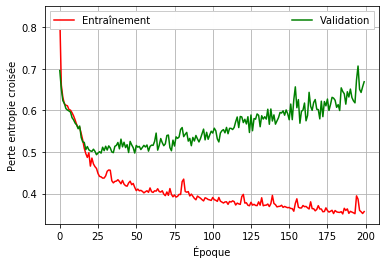

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(len(train_losses)))

ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label="Entraînement")
plt.plot(x, val_losses, 'g', label="Validation")
plt.xlabel('Époque')
plt.ylabel('Perte entropie croisée')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

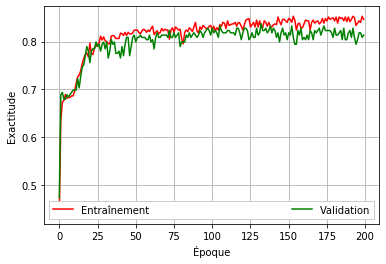

In [27]:
x = list(range(len(train_accuracies)))

ax = plt.subplot(111)
plt.plot(x, train_accuracies, 'r', label="Entraînement")
plt.plot(x, val_accuracies, 'g', label="Validation")
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

**Questions**:

* Qu'observez-vous dans les graphiques précédents ?
* À quelle époque est-il intéressant d'extraire les paramètres du modèle pour l'inférence ?


**Réponses possibles:**

* Le modèle apprend puisque la perte d'entraînement diminue. Cependant, nous pouvons observer en comparant les deux courbes de perte ( entraînement et validation) que le modèle commence à surapprendre à l'époque 25 par rapport à l'entropie croisée. Néanmoins, l'exactitude continue à augmenter jusqu'à l'époque 100.
* Autour de l'époque 125 où l'exactitude sur l'ensemble de validation est maximale. La mesure de performance est plus importante que la perte car c'est la mesure utilisée pour déterminer le meilleur modèle (c'est-à-dire la sélection du modèle). La perte d'entraînement n'est qu'un substitut nécessaire pour générer la rétroaction pour un modèle particulier. Un autre modèle pourrait utiliser une autre fonction de perte.


# Comment évaluer un modèle sur l'ensemble d’évaluation?


Nous pouvons enfin évaluer notre modèle sur notre ensemble de données d'évaluation.


In [28]:
test_loss, test_acc = evaluate(neural_net, test_loader, device)

Eval:  Perte moyenne: 0.53942   Exac: 164/209 (78.469%)


**Questions**:

A) Comparer les métriques de validation et d’évaluation. <br/>


**Réponse possible** : On observe un écart entre les deux mesures (validation : 81,8%, évaluation: 78,5%). Nous expliquons cette différence par le petit nombre d'exemples utilisés dans les deux ensembles (~ 209 exemples). Cela signifie que nos estimations actuelles peuvent présenter une variance de quelques pourcents. Pour l'évaluer plus précisément, nous pourrions utiliser une validation croisée k-fois.
